In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import mlflow
import mlflow.sklearn
from mlflow.store.artifact.runs_artifact_repo import RunsArtifactRepository
from mlflow.tracking import MlflowClient
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from mlflow.entities import SourceType, ViewType, RunTag, Run, RunInfo, ExperimentTag

In [2]:
#mlflow.sklearn.autolog()
mlflow.set_tracking_uri("databricks")

In [3]:
client = MlflowClient()
experiment_id = client.create_experiment("/mloassignment2_data_v1")

# Data Version 1

In [4]:
with mlflow.start_run(run_name = 'data_prep',experiment_id = experiment_id):
    base_dir = "/Users/bogu/Desktop/UChicago/2022Fall/MLOs"

    print("Loading Data...")
    
    telecom = pd.read_csv(
        f"{base_dir}/data_v1.csv")
    
    print("Data Loaded")
    
    row_count = (len(telecom))
    mlflow.log_param('raw_rows',row_count)
    
    # data cleaning
    telecom = telecom.dropna()

    telecom['voice_mail_plan'] = telecom['voice_mail_plan'].map(lambda x: x.strip())
    telecom['intl_plan'] = telecom['intl_plan'].map(lambda x: x.strip())
    telecom['churned'] = telecom['churned'].astype('str') 
    telecom['churned'] = telecom['churned'].map(lambda x: x.strip())
    telecom = telecom.replace(['True.', 'False.'], ['True','False']) 


    processd_row_count = (len(telecom))
    mlflow.log_param('processd_row_count', row_count)

    
    # Separate features and labels
    y = np.where(telecom['churned'] == 'True',1,0)
    ## Drop some useless columns
    to_drop = ['state','area_code','phone_number','churned']
    churn_feat_space = telecom.drop(to_drop, axis=1)
    ## converted yes and no
    yes_no_cols = ["intl_plan","voice_mail_plan"]
    churn_feat_space[yes_no_cols] = churn_feat_space[yes_no_cols] == 'yes'
    X = churn_feat_space


    # Split data into training set and test set
    test_size = 0.20
    random_state = 0
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=test_size, random_state=random_state)


    # Scale the data, using standardization
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    


    
    mlflow.log_param('test_weight',test_size)
    mlflow.log_param('random_state',random_state)

Loading Data...
Data Loaded


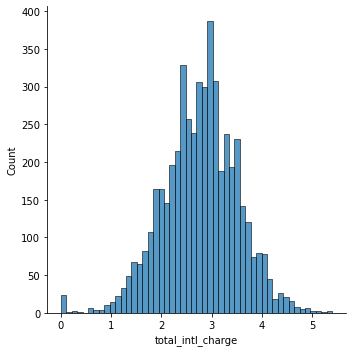

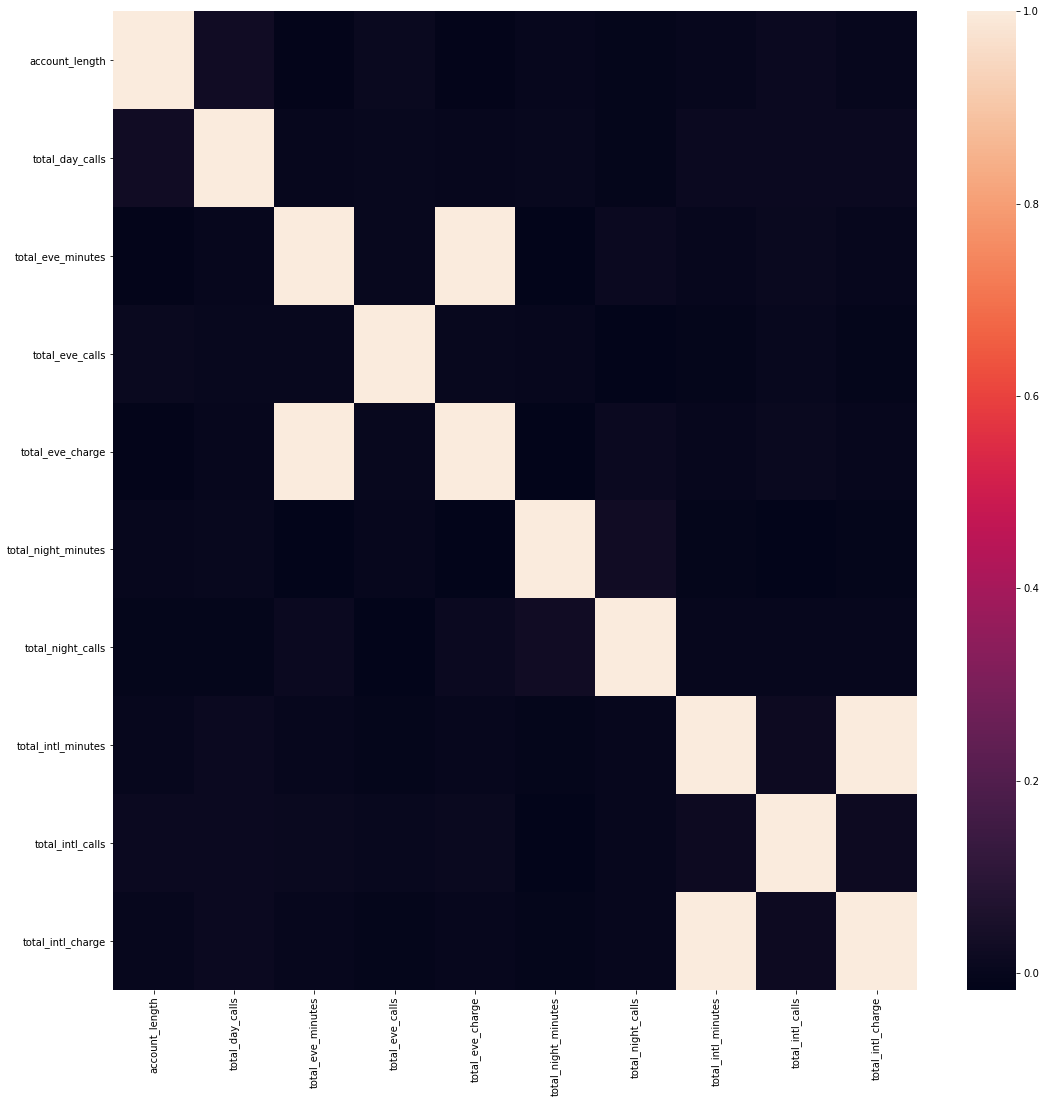

In [5]:
with mlflow.start_run(run_name='EDA',experiment_id = experiment_id) as run:
    # show international call charge dist plot
    dis_plot = sns.displot(telecom['total_intl_charge'])
    fig = dis_plot.savefig("dis_plot.png")
    plt.show()
    mlflow.log_artifact('dis_plot.png') 

    # show heapmap of correlations
    corr = telecom[["account_length",
                        "total_day_calls", "total_eve_minutes",
                        "total_eve_calls", "total_eve_charge", "total_night_minutes",
                        "total_night_calls", "total_intl_minutes", "total_intl_calls",
                        "total_intl_charge"]].corr()
    plt.figure(figsize = (18,18))
    heat_map = sns.heatmap(corr)
    figure = heat_map.get_figure()
    fig = figure.savefig("heatmap.png")
    plt.show()
    mlflow.log_artifact('heatmap.png') 

Training a logistic regression model...
Model Trained
Test Accuracy of: 0.877
Test Precision of: 0.5428571428571428
Test Recall of: 0.15079365079365079
Test F1 of: 0.2360248447204969
Test ROC_AUC Score of: 0.7578729432276343


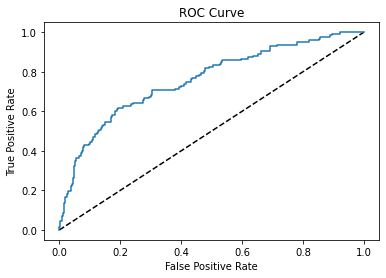

Training a logistic regression model...
Model Trained
Test Accuracy of: 0.877
Test Precision of: 0.5428571428571428
Test Recall of: 0.15079365079365079
Test F1 of: 0.2360248447204969
Test ROC_AUC Score of: 0.7578911045730267


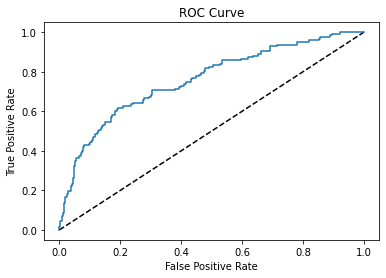

Training a logistic regression model...
Model Trained
Test Accuracy of: 0.877
Test Precision of: 0.5428571428571428
Test Recall of: 0.15079365079365079
Test F1 of: 0.2360248447204969
Test ROC_AUC Score of: 0.757900185245723


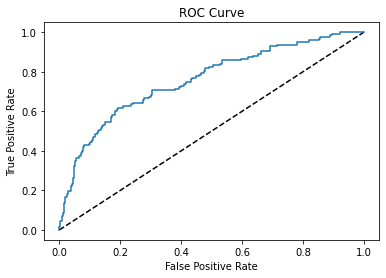

In [6]:
# Train the Logistic Regression model
# Possible hyperparamter options for Logistic Regression Regularization
# Penalty is choosed from L1 or L2
# C is the lambda value(weight) for L1 and L2

parameters = {
        'penalty':['l2'], 
        'C':[1, 5, 10]
    }


for penalty in parameters['penalty']:
    for c in parameters['C']:
        with mlflow.start_run(run_name='logistic_regression',experiment_id = experiment_id) as run:
            from sklearn.linear_model import LogisticRegression

            random_state=0
            
            print('Training a logistic regression model...')
            classifier_logistic = LogisticRegression(penalty = penalty, C=c, random_state=random_state)
            classifier_logistic.fit(X_train, y_train)

            print('Model Trained')

            # Log model
            mlflow.sklearn.log_model(classifier_logistic, "logistic-regression-model")

            # Log parameters
            mlflow.log_param('penalty', penalty)
            mlflow.log_param('C', c)
            mlflow.log_param('random_state', random_state)

            # make predictions
            y_hat = classifier_logistic.predict(X_test)
            y_probs = classifier_logistic.predict_proba(X_test)


            # Log metrics

            # calculate accuracy
            accuracy = sklearn.metrics.accuracy_score(y_test, y_hat)
            mlflow.log_metric("accuracy", accuracy)
            print("Test Accuracy of: {}".format(accuracy)) 

            # calculate precision
            precision = precision_score(y_test, y_hat)
            mlflow.log_metric("precision", precision)
            print("Test Precision of: {}".format(precision)) 

            # calculate recall
            recall = recall_score(y_test, y_hat)
            mlflow.log_metric("recall", recall)
            print("Test Recall of: {}".format(recall)) 

            # calculate f1
            f1 = f1_score(y_test, y_hat)
            mlflow.log_metric("f1", f1)
            print("Test F1 of: {}".format(f1)) 

            # calculate AUC

            auc = roc_auc_score(y_test,y_probs[:,1])

            mlflow.log_metric("auc", auc)
            print("Test ROC_AUC Score of: {}".format(auc)) 

            # plot ROC curve
            fpr, tpr, thresholds = roc_curve(y_test, y_probs[:,1])
            fig = plt.figure(figsize=(6, 4))
            # Plot the diagonal 50% line
            plt.plot([0, 1], [0, 1], 'k--')
            # Plot the FPR and TPR achieved by our model
            plt.plot(fpr, tpr)
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curve')
            plt.show()
            fig.savefig('ROC_CURVE.png')
            mlflow.log_artifact('ROC_CURVE.png') 


Training a random forest model...
Model n_estimators: 80
Model max_depth: 4
Model max_features: 5
Model random_state: 0
Model Trained
Test Accuracy of: 0.902
Test Precision of: 0.868421052631579
Test Recall of: 0.2619047619047619
Test F1 of: 0.402439024390244
Test ROC_AUC Score of: 0.8211243688932475


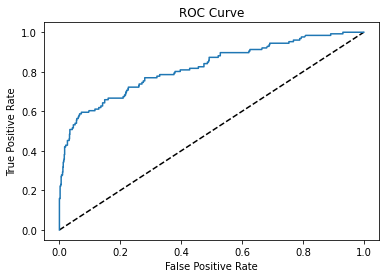

Training a random forest model...
Model n_estimators: 80
Model max_depth: 4
Model max_features: auto
Model random_state: 0
Model Trained
Test Accuracy of: 0.89
Test Precision of: 1.0
Test Recall of: 0.12698412698412698
Test F1 of: 0.22535211267605632
Test ROC_AUC Score of: 0.8102684246849006


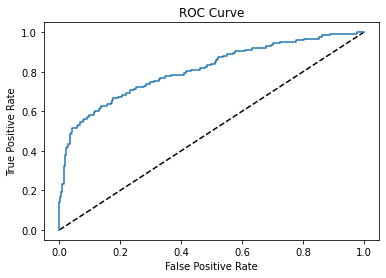

Training a random forest model...
Model n_estimators: 80
Model max_depth: 6
Model max_features: 5
Model random_state: 0
Model Trained
Test Accuracy of: 0.906
Test Precision of: 0.7758620689655172
Test Recall of: 0.35714285714285715
Test F1 of: 0.48913043478260876
Test ROC_AUC Score of: 0.829583015509789


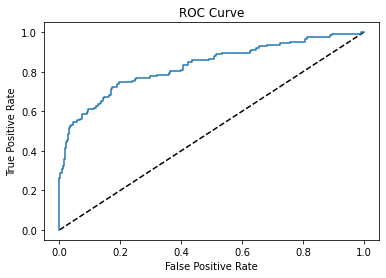

Training a random forest model...
Model n_estimators: 80
Model max_depth: 6
Model max_features: auto
Model random_state: 0
Model Trained
Test Accuracy of: 0.903
Test Precision of: 0.8536585365853658
Test Recall of: 0.2777777777777778
Test F1 of: 0.4191616766467066
Test ROC_AUC Score of: 0.818613562892739


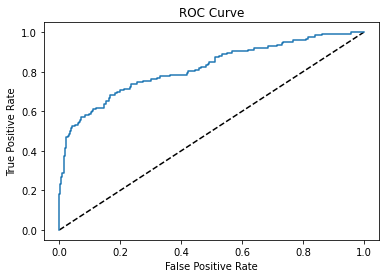

Training a random forest model...
Model n_estimators: 80
Model max_depth: 8
Model max_features: 5
Model random_state: 0
Model Trained
Test Accuracy of: 0.907
Test Precision of: 0.7619047619047619
Test Recall of: 0.38095238095238093
Test F1 of: 0.5079365079365079
Test ROC_AUC Score of: 0.8316897315753151


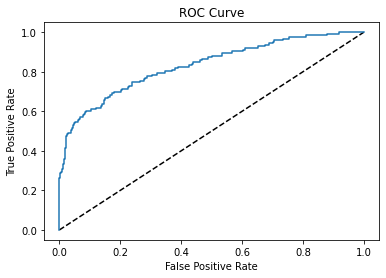

Training a random forest model...
Model n_estimators: 80
Model max_depth: 8
Model max_features: auto
Model random_state: 0
Model Trained
Test Accuracy of: 0.904
Test Precision of: 0.8
Test Recall of: 0.31746031746031744
Test F1 of: 0.45454545454545453
Test ROC_AUC Score of: 0.8208564890487088


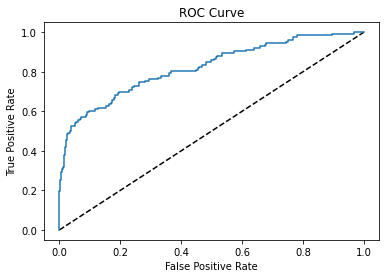

Training a random forest model...
Model n_estimators: 100
Model max_depth: 4
Model max_features: 5
Model random_state: 0
Model Trained
Test Accuracy of: 0.901
Test Precision of: 0.813953488372093
Test Recall of: 0.2777777777777778
Test F1 of: 0.4142011834319527
Test ROC_AUC Score of: 0.8207838436671389


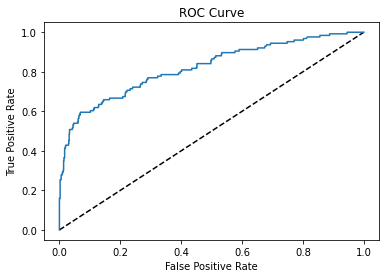

Training a random forest model...
Model n_estimators: 100
Model max_depth: 4
Model max_features: auto
Model random_state: 0
Model Trained
Test Accuracy of: 0.89
Test Precision of: 1.0
Test Recall of: 0.12698412698412698
Test F1 of: 0.22535211267605632
Test ROC_AUC Score of: 0.8119755911517925


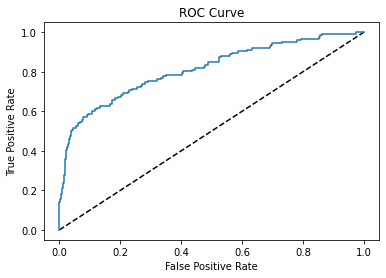

Training a random forest model...
Model n_estimators: 100
Model max_depth: 6
Model max_features: 5
Model random_state: 0
Model Trained
Test Accuracy of: 0.906
Test Precision of: 0.7758620689655172
Test Recall of: 0.35714285714285715
Test F1 of: 0.48913043478260876
Test ROC_AUC Score of: 0.8305364861428935


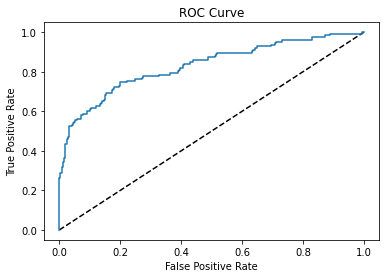

Training a random forest model...
Model n_estimators: 100
Model max_depth: 6
Model max_features: auto
Model random_state: 0
Model Trained
Test Accuracy of: 0.902
Test Precision of: 0.85
Test Recall of: 0.2698412698412698
Test F1 of: 0.40963855421686746
Test ROC_AUC Score of: 0.8198666957248193


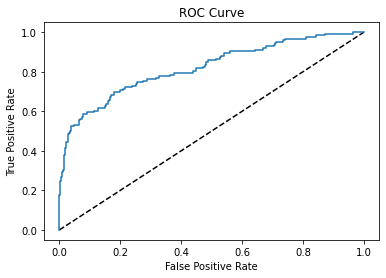

Training a random forest model...
Model n_estimators: 100
Model max_depth: 8
Model max_features: 5
Model random_state: 0
Model Trained
Test Accuracy of: 0.906
Test Precision of: 0.7580645161290323
Test Recall of: 0.373015873015873
Test F1 of: 0.5
Test ROC_AUC Score of: 0.830672696233337


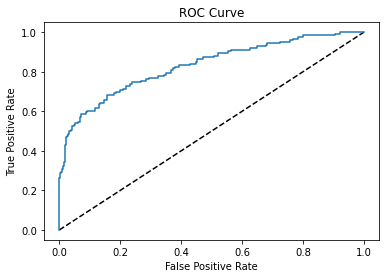

Training a random forest model...
Model n_estimators: 100
Model max_depth: 8
Model max_features: auto
Model random_state: 0
Model Trained
Test Accuracy of: 0.9
Test Precision of: 0.76
Test Recall of: 0.30158730158730157
Test F1 of: 0.43181818181818177
Test ROC_AUC Score of: 0.8192764519995642


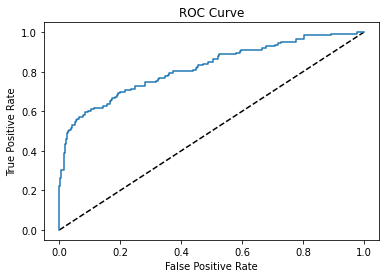

Training a random forest model...
Model n_estimators: 120
Model max_depth: 4
Model max_features: 5
Model random_state: 0
Model Trained
Test Accuracy of: 0.902
Test Precision of: 0.8333333333333334
Test Recall of: 0.2777777777777778
Test F1 of: 0.4166666666666667
Test ROC_AUC Score of: 0.82222767062584


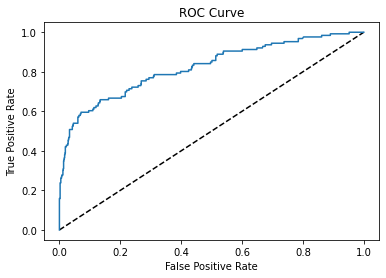

Training a random forest model...
Model n_estimators: 120
Model max_depth: 4
Model max_features: auto
Model random_state: 0
Model Trained
Test Accuracy of: 0.891
Test Precision of: 1.0
Test Recall of: 0.1349206349206349
Test F1 of: 0.23776223776223776
Test ROC_AUC Score of: 0.8117758163524755


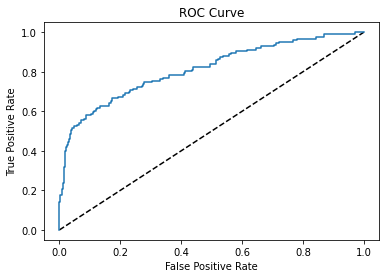

Training a random forest model...
Model n_estimators: 120
Model max_depth: 6
Model max_features: 5
Model random_state: 0
Model Trained
Test Accuracy of: 0.904
Test Precision of: 0.7678571428571429
Test Recall of: 0.3412698412698413
Test F1 of: 0.47252747252747257
Test ROC_AUC Score of: 0.8314445534125168


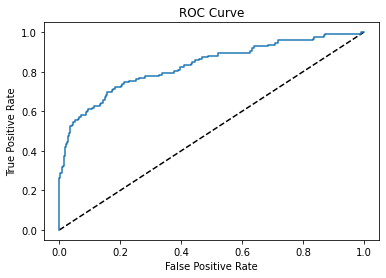

Training a random forest model...
Model n_estimators: 120
Model max_depth: 6
Model max_features: auto
Model random_state: 0
Model Trained
Test Accuracy of: 0.902
Test Precision of: 0.85
Test Recall of: 0.2698412698412698
Test F1 of: 0.40963855421686746
Test ROC_AUC Score of: 0.8215557008463188


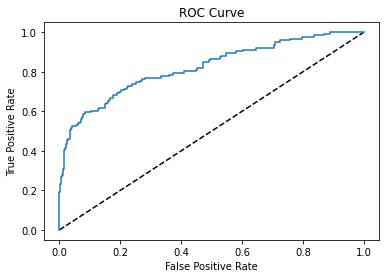

Training a random forest model...
Model n_estimators: 120
Model max_depth: 8
Model max_features: 5
Model random_state: 0
Model Trained
Test Accuracy of: 0.907
Test Precision of: 0.7619047619047619
Test Recall of: 0.38095238095238093
Test F1 of: 0.5079365079365079
Test ROC_AUC Score of: 0.832579637499546


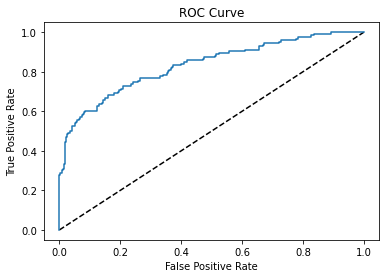

Training a random forest model...
Model n_estimators: 120
Model max_depth: 8
Model max_features: auto
Model random_state: 0
Model Trained
Test Accuracy of: 0.902
Test Precision of: 0.78
Test Recall of: 0.30952380952380953
Test F1 of: 0.4431818181818182
Test ROC_AUC Score of: 0.8209654571210635


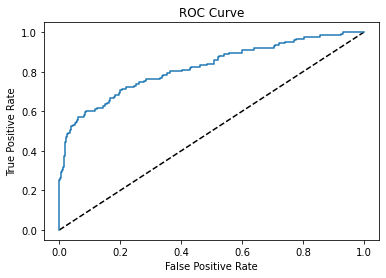

In [7]:
# Train the random forest model
# Possible hyperparamter options for Random Forest
# Choose the number of trees, maximum depth, and maximum features
parameters = {
    'n_estimators' : [80,100,120],
    'max_depth' : [4,6,8],
    'max_features' : [5,'auto']
}

for n_estimators in parameters['n_estimators']:
    for max_depth in parameters['max_depth']:
        for max_features in parameters['max_features']:
            with mlflow.start_run(run_name='random_forest',experiment_id = experiment_id) as run:
                from sklearn.ensemble import RandomForestClassifier

                random_state=0
                # Train the random forest model
                print('Training a random forest model...')
                print("Model n_estimators: {}".format(n_estimators)) 
                print("Model max_depth: {}".format(max_depth)) 
                print("Model max_features: {}".format(max_features)) 
                print("Model random_state: {}".format(random_state)) 
                
                classifier_rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features, random_state=random_state)
                classifier_rf.fit(X_train, y_train)
                print('Model Trained')

                # Log model
                mlflow.sklearn.log_model(classifier_rf, "random-forest-model")

                # Log parameters
                mlflow.log_param('n_estimators', n_estimators)
                mlflow.log_param('max_depth', max_depth)
                mlflow.log_param('max_features', max_features)
                mlflow.log_param('random_state', random_state)


                # Make predictions
                y_hat = classifier_rf.predict(X_test)
                y_probs = classifier_rf.predict_proba(X_test)


                # Log metrics
                accuracy = sklearn.metrics.accuracy_score(y_test, y_hat)
                mlflow.log_metric("accuracy", accuracy)
                print("Test Accuracy of: {}".format(accuracy)) 


                precision = precision_score(y_test, y_hat)
                mlflow.log_metric("precision", precision)
                print("Test Precision of: {}".format(precision)) 


                recall = recall_score(y_test, y_hat)
                mlflow.log_metric("recall", recall)
                print("Test Recall of: {}".format(recall)) 


                f1 = f1_score(y_test, y_hat)
                mlflow.log_metric("f1", f1)
                print("Test F1 of: {}".format(f1)) 


                auc = roc_auc_score(y_test, y_probs[:,1])
                mlflow.log_metric("auc", auc)
                print("Test ROC_AUC Score of: {}".format(auc)) 


                # plot ROC curve
                fpr, tpr, thresholds = roc_curve(y_test, y_probs[:,1])
                fig = plt.figure(figsize=(6, 4))
                # Plot the diagonal 50% line
                plt.plot([0, 1], [0, 1], 'k--')
                # Plot the FPR and TPR achieved by our model
                plt.plot(fpr, tpr)
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title('ROC Curve')
                plt.show()
                fig.savefig('ROC_CURVE.png')
                mlflow.log_artifact('ROC_CURVE.png') 


In [8]:
def get_best_model(exp_name: str , metric: str, tracking_uri='databricks'):
    """ Get Best Model From MLflow
    
    Keyword Arguments:
    exp_name -- MLflow experiment name
    metric -- Scoring metric to filter best model
    tracking_url -- remote tracking uri
    """
    
    mlflow.set_tracking_uri(tracking_uri)
    print('MLflow Tracking URI: ', mlflow.get_tracking_uri())
    expid = MlflowClient().get_experiment_by_name(exp_name).experiment_id
    runs = MlflowClient().search_runs(
        experiment_ids = expid,
        filter_string = "",
        run_view_type=ViewType.ACTIVE_ONLY,
        max_results=1,
        order_by = [f"metrics.{metric} DESC"])
    runid = runs[0].info.run_id
    best_run = runs[0]
    log_metrics = best_run.data.metrics
    print(f"MLflow Exp: {exp_name} -- Expid: {expid} -- Best Model: {runid}")
    print(log_metrics)
    return expid, runid, log_metrics



In [9]:
get_best_model(exp_name='/mloassignment2_data_v1', metric='f1')

MLflow Tracking URI:  databricks
MLflow Exp: /mloassignment2_data_v1 -- Expid: 1973317453061113 -- Best Model: d0ddb4c72db949e2955145748c20b028
{'accuracy': 0.907, 'auc': 0.832579637499546, 'f1': 0.5079365079365079, 'precision': 0.7619047619047619, 'recall': 0.38095238095238093}


('1973317453061113',
 'd0ddb4c72db949e2955145748c20b028',
 {'accuracy': 0.907,
  'auc': 0.832579637499546,
  'f1': 0.5079365079365079,
  'precision': 0.7619047619047619,
  'recall': 0.38095238095238093})

# Data V2 
## Adding Features ['total_day_minutes', 'total_day_charge', 'number_vmail_messages']

In [10]:
client = MlflowClient()
experiment_id = client.create_experiment("/mloassignment2_data_v2")

In [11]:
with mlflow.start_run(run_name = 'data_prep',experiment_id = experiment_id):
    base_dir = "/Users/bogu/Desktop/UChicago/2022Fall/MLOs"

    print("Loading Data...")
    
    telecom = pd.read_csv(
        f"{base_dir}/data_v2.csv")
    
    print("Data Loaded")
    
    row_count = (len(telecom))
    mlflow.log_param('raw_rows',row_count)
    
    # data cleaning
    telecom = telecom.dropna()

    telecom['voice_mail_plan'] = telecom['voice_mail_plan'].map(lambda x: x.strip())
    telecom['intl_plan'] = telecom['intl_plan'].map(lambda x: x.strip())
    telecom['churned'] = telecom['churned'].astype('str') 
    telecom['churned'] = telecom['churned'].map(lambda x: x.strip())
    telecom = telecom.replace(['True.', 'False.'], ['True','False']) 


    processd_row_count = (len(telecom))
    mlflow.log_param('processd_row_count', row_count)

    
    # Separate features and labels
    y = np.where(telecom['churned'] == 'True',1,0)
    ## Drop some useless columns
    to_drop = ['state','area_code','phone_number','churned']
    churn_feat_space = telecom.drop(to_drop, axis=1)
    ## converted yes and no
    yes_no_cols = ["intl_plan","voice_mail_plan"]
    churn_feat_space[yes_no_cols] = churn_feat_space[yes_no_cols] == 'yes'
    X = churn_feat_space


    # Split data into training set and test set
    test_size = 0.20
    random_state = 0
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=test_size, random_state=random_state)


    # Scale the data, using standardization
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    


    
    mlflow.log_param('test_weight',test_size)
    mlflow.log_param('random_state',random_state)

Loading Data...
Data Loaded


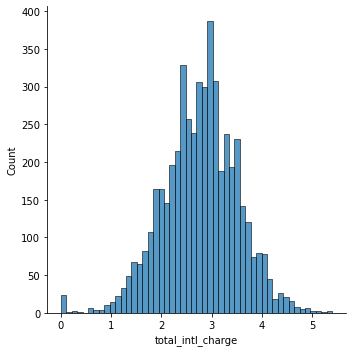

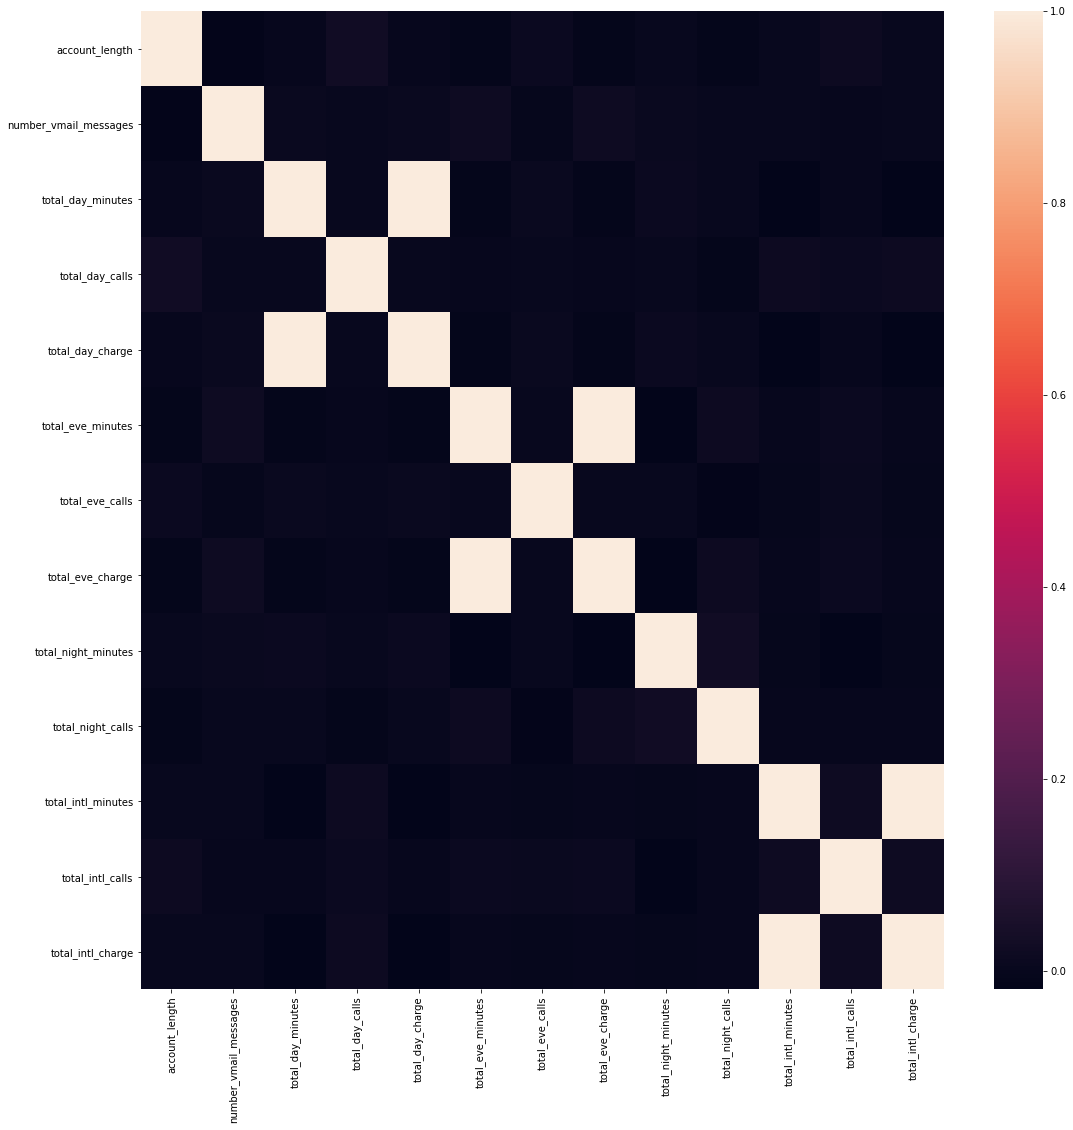

In [12]:
with mlflow.start_run(run_name='EDA',experiment_id = experiment_id) as run:
    # show international call charge dist plot
    dis_plot = sns.displot(telecom['total_intl_charge'])
    fig = dis_plot.savefig("dis_plot.png")
    plt.show()
    mlflow.log_artifact('dis_plot.png') 

    # show heapmap of correlations
    corr = telecom[["account_length", "number_vmail_messages", "total_day_minutes",
                        "total_day_calls", "total_day_charge", "total_eve_minutes",
                        "total_eve_calls", "total_eve_charge", "total_night_minutes",
                        "total_night_calls", "total_intl_minutes", "total_intl_calls",
                        "total_intl_charge"]].corr()
    plt.figure(figsize = (18,18))
    heat_map = sns.heatmap(corr)
    figure = heat_map.get_figure()
    fig = figure.savefig("heatmap.png")
    plt.show()
    mlflow.log_artifact('heatmap.png') 

Training a logistic regression model...
Model Trained
Test Accuracy of: 0.874
Test Precision of: 0.5
Test Recall of: 0.21428571428571427
Test F1 of: 0.3
Test ROC_AUC Score of: 0.8213831680650903


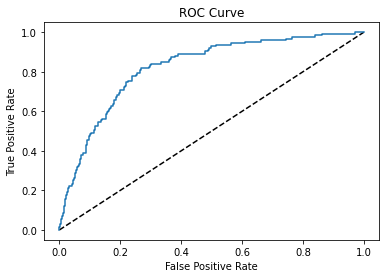

Training a logistic regression model...
Model Trained
Test Accuracy of: 0.874
Test Precision of: 0.5
Test Recall of: 0.21428571428571427
Test F1 of: 0.3
Test ROC_AUC Score of: 0.8210290218299371


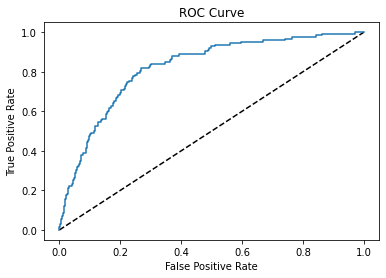

Training a logistic regression model...
Model Trained
Test Accuracy of: 0.874
Test Precision of: 0.5
Test Recall of: 0.21428571428571427
Test F1 of: 0.3
Test ROC_AUC Score of: 0.8209382151029747


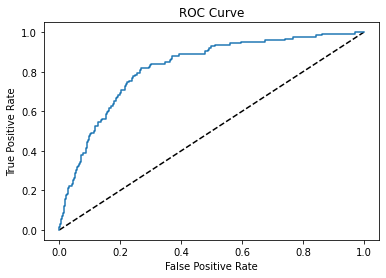

In [13]:
# Train the Logistic Regression model
# Possible hyperparamter options for Logistic Regression Regularization
# Penalty is choosed from L1 or L2
# C is the lambda value(weight) for L1 and L2

parameters = {
        'penalty':['l2'], 
        'C':[1, 5, 10]
    }


for penalty in parameters['penalty']:
    for c in parameters['C']:
        with mlflow.start_run(run_name='logistic_regression',experiment_id = experiment_id) as run:
            from sklearn.linear_model import LogisticRegression

            random_state=0
            
            print('Training a logistic regression model...')
            classifier_logistic = LogisticRegression(penalty = penalty, C=c, random_state=random_state)
            classifier_logistic.fit(X_train, y_train)

            print('Model Trained')

            # Log model
            mlflow.sklearn.log_model(classifier_logistic, "logistic-regression-model")

            # Log parameters
            mlflow.log_param('penalty', penalty)
            mlflow.log_param('C', c)
            mlflow.log_param('random_state', random_state)

            # make predictions
            y_hat = classifier_logistic.predict(X_test)
            y_probs = classifier_logistic.predict_proba(X_test)


            # Log metrics

            # calculate accuracy
            accuracy = sklearn.metrics.accuracy_score(y_test, y_hat)
            mlflow.log_metric("accuracy", accuracy)
            print("Test Accuracy of: {}".format(accuracy)) 

            # calculate precision
            precision = precision_score(y_test, y_hat)
            mlflow.log_metric("precision", precision)
            print("Test Precision of: {}".format(precision)) 

            # calculate recall
            recall = recall_score(y_test, y_hat)
            mlflow.log_metric("recall", recall)
            print("Test Recall of: {}".format(recall)) 

            # calculate f1
            f1 = f1_score(y_test, y_hat)
            mlflow.log_metric("f1", f1)
            print("Test F1 of: {}".format(f1)) 

            # calculate AUC

            auc = roc_auc_score(y_test,y_probs[:,1])

            mlflow.log_metric("auc", auc)
            print("Test ROC_AUC Score of: {}".format(auc)) 

            # plot ROC curve
            fpr, tpr, thresholds = roc_curve(y_test, y_probs[:,1])
            fig = plt.figure(figsize=(6, 4))
            # Plot the diagonal 50% line
            plt.plot([0, 1], [0, 1], 'k--')
            # Plot the FPR and TPR achieved by our model
            plt.plot(fpr, tpr)
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curve')
            plt.show()
            fig.savefig('ROC_CURVE.png')
            mlflow.log_artifact('ROC_CURVE.png') 


Training a random forest model...
Model n_estimators: 80
Model max_depth: 4
Model max_features: 5
Model random_state: 0
Model Trained
Test Accuracy of: 0.921
Test Precision of: 0.9433962264150944
Test Recall of: 0.3968253968253968
Test F1 of: 0.5586592178770949
Test ROC_AUC Score of: 0.9260969452617049


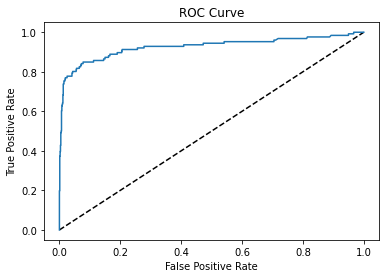

Training a random forest model...
Model n_estimators: 80
Model max_depth: 4
Model max_features: auto
Model random_state: 0
Model Trained
Test Accuracy of: 0.902
Test Precision of: 0.8888888888888888
Test Recall of: 0.25396825396825395
Test F1 of: 0.3950617283950617
Test ROC_AUC Score of: 0.9249527805019796


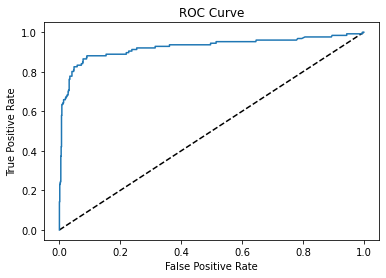

Training a random forest model...
Model n_estimators: 80
Model max_depth: 6
Model max_features: 5
Model random_state: 0
Model Trained
Test Accuracy of: 0.959
Test Precision of: 0.956989247311828
Test Recall of: 0.7063492063492064
Test F1 of: 0.8127853881278538
Test ROC_AUC Score of: 0.9344193817878027


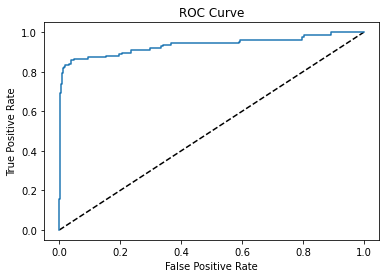

Training a random forest model...
Model n_estimators: 80
Model max_depth: 6
Model max_features: auto
Model random_state: 0
Model Trained
Test Accuracy of: 0.958
Test Precision of: 0.9772727272727273
Test Recall of: 0.6825396825396826
Test F1 of: 0.8037383177570094
Test ROC_AUC Score of: 0.9301605462932694


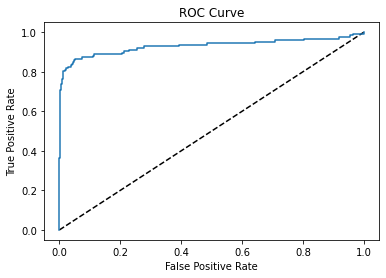

Training a random forest model...
Model n_estimators: 80
Model max_depth: 8
Model max_features: 5
Model random_state: 0
Model Trained
Test Accuracy of: 0.963
Test Precision of: 0.9405940594059405
Test Recall of: 0.753968253968254
Test F1 of: 0.8370044052863436
Test ROC_AUC Score of: 0.9326486506120374


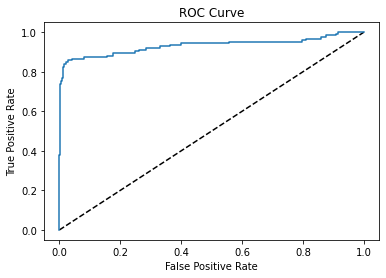

Training a random forest model...
Model n_estimators: 80
Model max_depth: 8
Model max_features: auto
Model random_state: 0
Model Trained
Test Accuracy of: 0.963
Test Precision of: 0.9320388349514563
Test Recall of: 0.7619047619047619
Test F1 of: 0.8384279475982533
Test ROC_AUC Score of: 0.9277904907195526


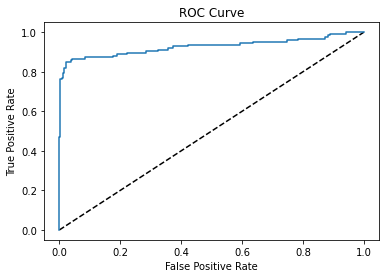

Training a random forest model...
Model n_estimators: 100
Model max_depth: 4
Model max_features: 5
Model random_state: 0
Model Trained
Test Accuracy of: 0.921
Test Precision of: 0.9433962264150944
Test Recall of: 0.3968253968253968
Test F1 of: 0.5586592178770949
Test ROC_AUC Score of: 0.9258926301260397


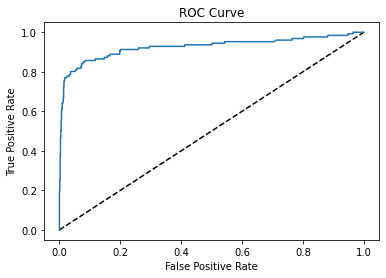

Training a random forest model...
Model n_estimators: 100
Model max_depth: 4
Model max_features: auto
Model random_state: 0
Model Trained
Test Accuracy of: 0.9
Test Precision of: 0.8823529411764706
Test Recall of: 0.23809523809523808
Test F1 of: 0.37499999999999994
Test ROC_AUC Score of: 0.9253704914460062


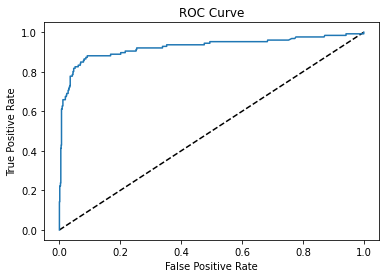

Training a random forest model...
Model n_estimators: 100
Model max_depth: 6
Model max_features: 5
Model random_state: 0
Model Trained
Test Accuracy of: 0.959
Test Precision of: 0.967032967032967
Test Recall of: 0.6984126984126984
Test F1 of: 0.8110599078341014
Test ROC_AUC Score of: 0.9342196069884856


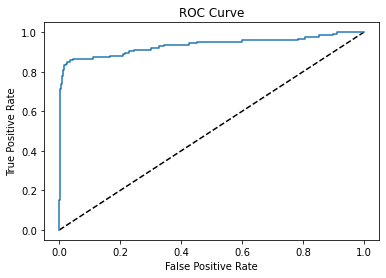

Training a random forest model...
Model n_estimators: 100
Model max_depth: 6
Model max_features: auto
Model random_state: 0
Model Trained
Test Accuracy of: 0.954
Test Precision of: 0.9545454545454546
Test Recall of: 0.6666666666666666
Test F1 of: 0.7850467289719627
Test ROC_AUC Score of: 0.9313955177799572


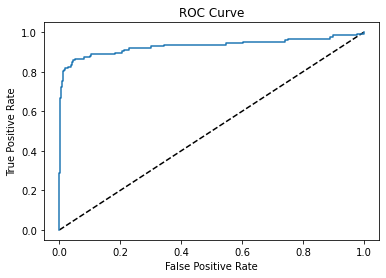

Training a random forest model...
Model n_estimators: 100
Model max_depth: 8
Model max_features: 5
Model random_state: 0
Model Trained
Test Accuracy of: 0.965
Test Precision of: 0.9595959595959596
Test Recall of: 0.753968253968254
Test F1 of: 0.8444444444444444
Test ROC_AUC Score of: 0.9327394573389997


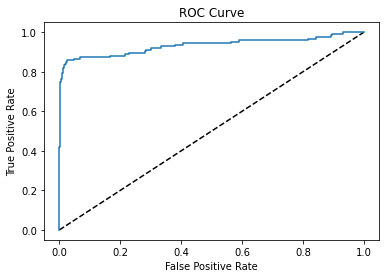

Training a random forest model...
Model n_estimators: 100
Model max_depth: 8
Model max_features: auto
Model random_state: 0
Model Trained
Test Accuracy of: 0.965
Test Precision of: 0.9595959595959596
Test Recall of: 0.753968253968254
Test F1 of: 0.8444444444444444
Test ROC_AUC Score of: 0.9278177327376413


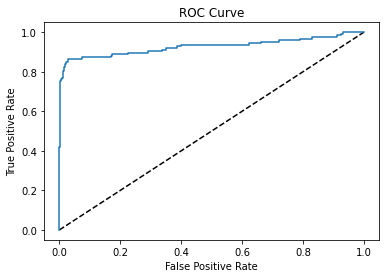

Training a random forest model...
Model n_estimators: 120
Model max_depth: 4
Model max_features: 5
Model random_state: 0
Model Trained
Test Accuracy of: 0.921
Test Precision of: 0.9433962264150944
Test Recall of: 0.3968253968253968
Test F1 of: 0.5586592178770949
Test ROC_AUC Score of: 0.9259970578620463


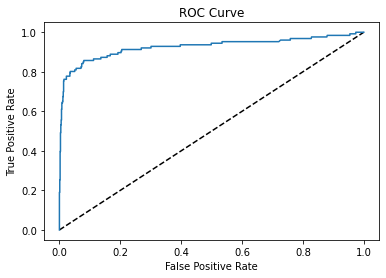

Training a random forest model...
Model n_estimators: 120
Model max_depth: 4
Model max_features: auto
Model random_state: 0
Model Trained
Test Accuracy of: 0.899
Test Precision of: 0.8787878787878788
Test Recall of: 0.23015873015873015
Test F1 of: 0.36477987421383645
Test ROC_AUC Score of: 0.9280538302277432


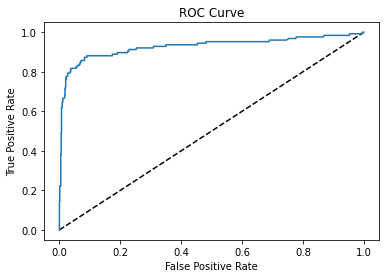

Training a random forest model...
Model n_estimators: 120
Model max_depth: 6
Model max_features: 5
Model random_state: 0
Model Trained
Test Accuracy of: 0.959
Test Precision of: 0.967032967032967
Test Recall of: 0.6984126984126984
Test F1 of: 0.8110599078341014
Test ROC_AUC Score of: 0.9355363045294396


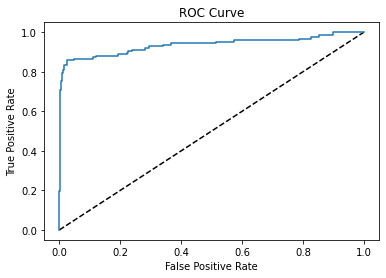

Training a random forest model...
Model n_estimators: 120
Model max_depth: 6
Model max_features: auto
Model random_state: 0
Model Trained
Test Accuracy of: 0.955
Test Precision of: 0.9655172413793104
Test Recall of: 0.6666666666666666
Test F1 of: 0.7887323943661971
Test ROC_AUC Score of: 0.9308779194362717


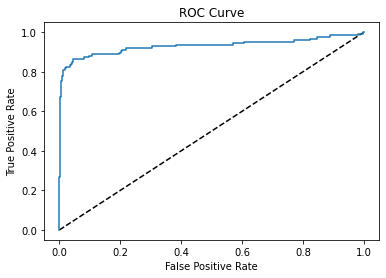

Training a random forest model...
Model n_estimators: 120
Model max_depth: 8
Model max_features: 5
Model random_state: 0
Model Trained
Test Accuracy of: 0.966
Test Precision of: 0.96
Test Recall of: 0.7619047619047619
Test F1 of: 0.8495575221238937
Test ROC_AUC Score of: 0.935436417129781


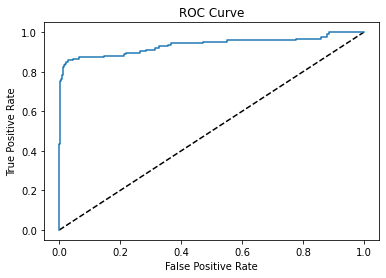

Training a random forest model...
Model n_estimators: 120
Model max_depth: 8
Model max_features: auto
Model random_state: 0
Model Trained
Test Accuracy of: 0.966
Test Precision of: 0.9693877551020408
Test Recall of: 0.753968253968254
Test F1 of: 0.8482142857142858
Test ROC_AUC Score of: 0.9299244488031674


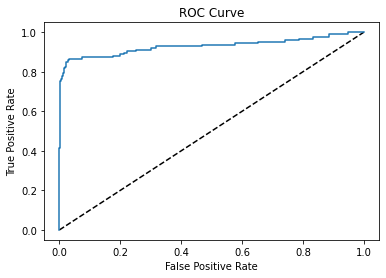

In [14]:
# Train the random forest model
# Possible hyperparamter options for Random Forest
# Choose the number of trees, maximum depth, and maximum features
parameters = {
    'n_estimators' : [80,100,120],
    'max_depth' : [4,6,8],
    'max_features' : [5,'auto']
}

for n_estimators in parameters['n_estimators']:
    for max_depth in parameters['max_depth']:
        for max_features in parameters['max_features']:
            with mlflow.start_run(run_name='random_forest',experiment_id = experiment_id) as run:
                from sklearn.ensemble import RandomForestClassifier

                random_state=0
                # Train the random forest model
                print('Training a random forest model...')
                print("Model n_estimators: {}".format(n_estimators)) 
                print("Model max_depth: {}".format(max_depth)) 
                print("Model max_features: {}".format(max_features)) 
                print("Model random_state: {}".format(random_state)) 
                
                classifier_rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features, random_state=random_state)
                classifier_rf.fit(X_train, y_train)
                print('Model Trained')

                # Log model
                mlflow.sklearn.log_model(classifier_rf, "random-forest-model")

                # Log parameters
                mlflow.log_param('n_estimators', n_estimators)
                mlflow.log_param('max_depth', max_depth)
                mlflow.log_param('max_features', max_features)
                mlflow.log_param('random_state', random_state)


                # Make predictions
                y_hat = classifier_rf.predict(X_test)
                y_probs = classifier_rf.predict_proba(X_test)


                # Log metrics
                accuracy = sklearn.metrics.accuracy_score(y_test, y_hat)
                mlflow.log_metric("accuracy", accuracy)
                print("Test Accuracy of: {}".format(accuracy)) 


                precision = precision_score(y_test, y_hat)
                mlflow.log_metric("precision", precision)
                print("Test Precision of: {}".format(precision)) 


                recall = recall_score(y_test, y_hat)
                mlflow.log_metric("recall", recall)
                print("Test Recall of: {}".format(recall)) 


                f1 = f1_score(y_test, y_hat)
                mlflow.log_metric("f1", f1)
                print("Test F1 of: {}".format(f1)) 


                auc = roc_auc_score(y_test, y_probs[:,1])
                mlflow.log_metric("auc", auc)
                print("Test ROC_AUC Score of: {}".format(auc)) 


                # plot ROC curve
                fpr, tpr, thresholds = roc_curve(y_test, y_probs[:,1])
                fig = plt.figure(figsize=(6, 4))
                # Plot the diagonal 50% line
                plt.plot([0, 1], [0, 1], 'k--')
                # Plot the FPR and TPR achieved by our model
                plt.plot(fpr, tpr)
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title('ROC Curve')
                plt.show()
                fig.savefig('ROC_CURVE.png')
                mlflow.log_artifact('ROC_CURVE.png') 


In [15]:
get_best_model(exp_name='/mloassignment2_data_v2', metric='f1')

MLflow Tracking URI:  databricks
MLflow Exp: /mloassignment2_data_v2 -- Expid: 1973317453061114 -- Best Model: 81ba468c3f594c6da1290058ac5c7522
{'accuracy': 0.966, 'auc': 0.935436417129781, 'f1': 0.8495575221238937, 'precision': 0.96, 'recall': 0.7619047619047619}


('1973317453061114',
 '81ba468c3f594c6da1290058ac5c7522',
 {'accuracy': 0.966,
  'auc': 0.935436417129781,
  'f1': 0.8495575221238937,
  'precision': 0.96,
  'recall': 0.7619047619047619})